# DecisionTree model experamentation

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [310]:
df = pd.read_csv('../data/finalized_customer_churn_records.csv')
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,...,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0.00,1,1,1,101348.88,1,1,...,464,1,0,0,1,0,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,...,456,0,0,1,1,0,1,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,...,377,1,0,0,1,0,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,...,350,1,0,0,1,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,...,425,0,0,1,1,0,0,1,0,0


In [311]:
target_variable = df['Exited'].values
df.drop(columns='Exited', axis=1, inplace=True)

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Age                 10000 non-null  int64  
 2   Tenure              10000 non-null  int64  
 3   Balance             10000 non-null  float64
 4   NumOfProducts       10000 non-null  int64  
 5   HasCrCard           10000 non-null  int64  
 6   IsActiveMember      10000 non-null  int64  
 7   EstimatedSalary     10000 non-null  float64
 8   Complain            10000 non-null  int64  
 9   Satisfaction Score  10000 non-null  int64  
 10  Point Earned        10000 non-null  int64  
 11  Geography_France    10000 non-null  int64  
 12  Geography_Germany   10000 non-null  int64  
 13  Geography_Spain     10000 non-null  int64  
 14  Gender_Female       10000 non-null  int64  
 15  Gender_Male         10000 non-null  int64  
 16  Card 

In [313]:
numeric = df.select_dtypes(exclude=['object'])
non_numeric = df.select_dtypes(include=['object'])


## Split data into training and testing sets

In [314]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler

# scaler = MinMaxScaler()

over_sampler = RandomOverSampler(sampling_strategy='minority')
df, target_variable = over_sampler.fit_resample(df, target_variable)

RANDOM_STATE = 3

X_train, X_test, y_train, y_test = train_test_split(df, target_variable, stratify=target_variable, random_state=RANDOM_STATE, test_size=0.30)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)



X_train shape: (11146, 20)
y_train shape: (11146,)
X_test shape: (4778, 20)
y_test shape: (4778,)


## Basic Decision Tree model implementation
* We will start with a max_depth=3 and min_sample_leaf=5, per the documentation

In [315]:
d_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, min_samples_leaf=5, max_depth=3)

%time
d_tree.fit(X_train, y_train)


CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 207 µs


DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=3)

In [316]:
from sklearn.metrics import classification_report, confusion_matrix

d_tree_preds = d_tree.predict(X_test)

print(classification_report(y_test, d_tree_preds))

confusion_matrix_ = confusion_matrix(y_test, d_tree_preds)

print(f'False negative rate:\n{confusion_matrix_[0][1]/len(y_test)*100}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778

False negative rate:
0.06278777731268313


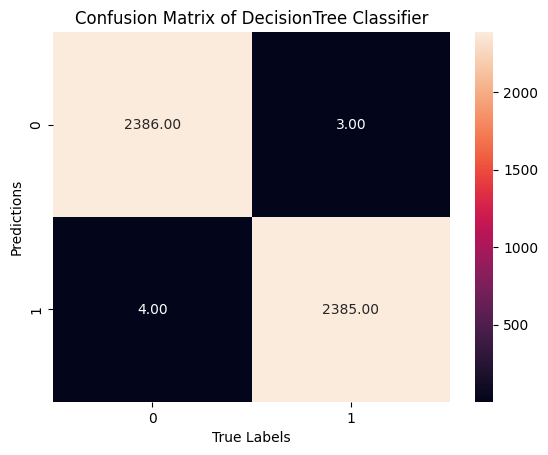

In [317]:
sns.heatmap(data=confusion_matrix_, annot=True, fmt='.2f')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Confusion Matrix of DecisionTree Classifier')
plt.show()

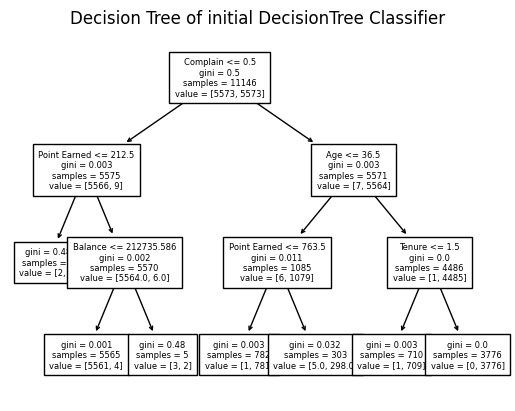

In [318]:
tree.plot_tree(d_tree, feature_names=df.columns, fontsize=6)
plt.title('Decision Tree of initial DecisionTree Classifier')
plt.show()

We can see the decision tree is making its initial decision on 'Complain', the next level splits at 'Point Earned' and 'Age', the next level on 'Balance', and 'Tenure'.
- Next we will tune some hyper-parameters

In [319]:
params = {
    'min_samples_leaf': np.arange(1,10),
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3,4,5]
}

d_tree_grid = GridSearchCV(estimator=d_tree, param_grid=params, cv=5, verbose=2, scoring=['f1_weighted', 'recall'], refit='f1_weighted')

d_tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_s

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, min_samples_leaf=5,
                                              random_state=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             refit='f1_weighted', scoring=['f1_weighted', 'recall'], verbose=2)

In [320]:
d_tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

### Final DecisionTree Classifier

In [321]:
d_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='gini', max_depth=5, min_samples_leaf=1)

%time
d_tree.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 21 µs


DecisionTreeClassifier(max_depth=5, random_state=3)

In [322]:
d_tree_preds = d_tree.predict(X_test)

## Scoring

In [323]:
print(classification_report(y_test, d_tree_preds))
confusion_matrix_ = confusion_matrix(y_test, d_tree_preds)

print(f'False negative rate:\n{confusion_matrix_[0][1]/len(y_test)*100}')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778

False negative rate:
0.06278777731268313


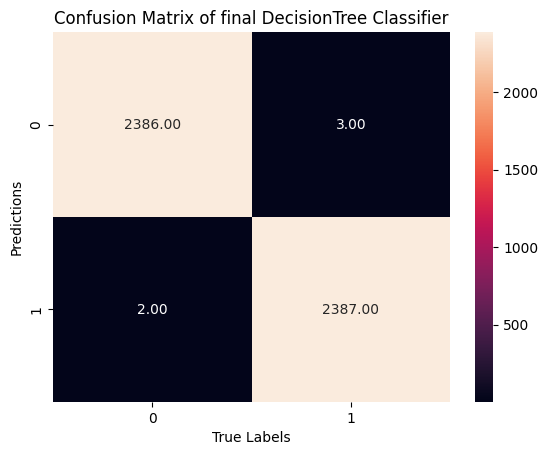

In [324]:
sns.heatmap(data=confusion_matrix_, fmt='.2f', annot=True)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Confusion Matrix of final DecisionTree Classifier')
plt.show()


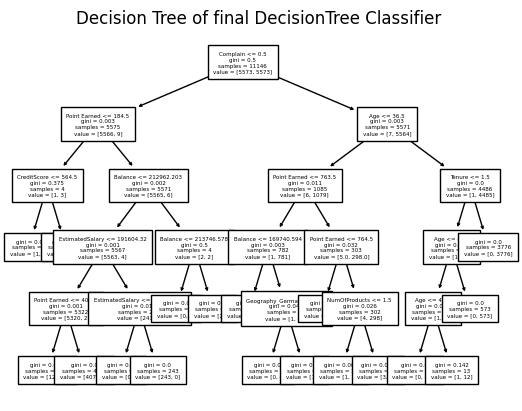

In [325]:
tree.plot_tree(d_tree, feature_names=df.columns, fontsize=4)
plt.title('Decision Tree of final DecisionTree Classifier')
plt.show()

In [326]:
feature_importances = d_tree.feature_importances_

feature_df = pd.DataFrame({
    'Features': df.columns,
    'Importance': feature_importances,
    'Importance_as_%': [(feature * 100) for feature in feature_importances]
})

feature_df.drop(columns=['Importance'], axis=1, inplace=True)
feature_df.sort_values(by='Importance_as_%', ascending=False, inplace=True)

feature_df.head(10)

,Features,Importance_as_%
8,Complain,99.669402
10,Point Earned,0.117475
3,Balance,0.072524
7,EstimatedSalary,0.071874
12,Geography_Germany,0.035225
0,CreditScore,0.026981
1,Age,0.003602
4,NumOfProducts,0.002874
2,Tenure,0.000043
6,IsActiveMember,0.000000


The final tree is shown with 'Complain' as the root node, the next layer of internal nodes are the same as the tree from the initial implementation of the decision tree classifier and the subsequent layers of internal nodes are made up of the top 10 features shown in the dataframe above.

## Save Model

In [327]:
import pickle

with open('../final_models/decision_tree_model.pkl', 'wb') as model:
    pickle.dump(d_tree, model)